
### Rubina Iman Kabir 


In [1]:
# Packages
import pandas as pd
import scipy.stats as st
from scipy import stats, interp
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import mse
import numpy as np
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,auc, accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from statsmodels.discrete.discrete_model import Logit
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from pandas.plotting import scatter_matrix
import xgboost as xgb

# 1. The LASSO and Bootsting For Regression

##### (a) - (b) Import Data  and Impute

In [2]:
cols = ['population','householdsize','racepctblack','racePctWhite','racePctAsian',
'racePctHisp','agePct12t21','agePct12t29','agePct16t24','agePct65up','numbUrban',
'pctUrban','medIncome','pctWWage','pctWFarmSelf','pctWInvInc','pctWSocSec','pctWPubAsst',
'pctWRetire','medFamInc','perCapInc','whitePerCap','blackPerCap','indianPerCap',
'AsianPerCap','OtherPerCap','HispPerCap','NumUnderPov','PctPopUnderPov','PctLess9thGrade',
'PctNotHSGrad','PctBSorMore','PctUnemployed','PctEmploy','PctEmplManu','PctEmplProfServ',
'PctOccupManu','PctOccupMgmtProf','MalePctDivorce','MalePctNevMarr','FemalePctDiv','TotalPctDiv',
'PersPerFam','PctFam2Par','PctKids2Par','PctYoungKids2Par','PctTeen2Par','PctWorkMomYoungKids',
'PctWorkMom','NumIlleg','PctIlleg','NumImmig','PctImmigRecent','PctImmigRec5','PctImmigRec8',
'PctImmigRec10','PctRecentImmig','PctRecImmig5','PctRecImmig8','PctRecImmig10','PctSpeakEnglOnly',
'PctNotSpeakEnglWell','PctLargHouseFam','PctLargHouseOccup','PersPerOccupHous','PersPerOwnOccHous',
'PersPerRentOccHous','PctPersOwnOccup','PctPersDenseHous','PctHousLess3BR','MedNumBR',
'HousVacant','PctHousOccup','PctHousOwnOcc','PctVacantBoarded','PctVacMore6Mos',
'MedYrHousBuilt','PctHousNoPhone','PctWOFullPlumb','OwnOccLowQuart','OwnOccMedVal',
'OwnOccHiQuart','RentLowQ','RentMedian','RentHighQ','MedRent','MedRentPctHousInc',
'MedOwnCostPctInc','MedOwnCostPctIncNoMtg','NumInShelters','NumStreet','PctForeignBorn',
'PctBornSameState','PctSameHouse85','PctSameCity85','PctSameState85','LemasSwornFT',
'LemasSwFTPerPop','LemasSwFTFieldOps','LemasSwFTFieldPerPop','LemasTotalReq','LemasTotReqPerPop',
'PolicReqPerOffic','PolicPerPop','RacialMatchCommPol','PctPolicWhite','PctPolicBlack',
'PctPolicHisp','PctPolicAsian','PctPolicMinor','OfficAssgnDrugUnits','NumKindsDrugsSeiz',
'PolicAveOTWorked','LandArea','PopDens','PctUsePubTrans','PolicCars',
'PolicOperBudg','LemasPctPolicOnPatr','LemasGangUnitDeploy','LemasPctOfficDrugUn','PolicBudgPerPop',
'ViolentCrimesPerPop']
data = pd.read_csv('communities.csv',sep = ',', header = None,usecols = range(5,128))
data.columns = cols
data.replace(to_replace= '?', value= np.nan, inplace=True)
data= data.astype('float')
nans = data.loc[:,data.isna().any()].columns


# Relpace missing values with means of associated predictor
means = data.mean()
for col in nans:
    if sum(np.isnan(data[col].values)) > 0:
        new = []
        for elem in data[col].values:
            if np.isnan(elem) == True:
                new.append(means[col])
            else:
                new.append(elem)
        data[col] = new         

Data imputation was done by replacing missing values with the means of the associated feature

##### (c) Plot Correlation Matrix

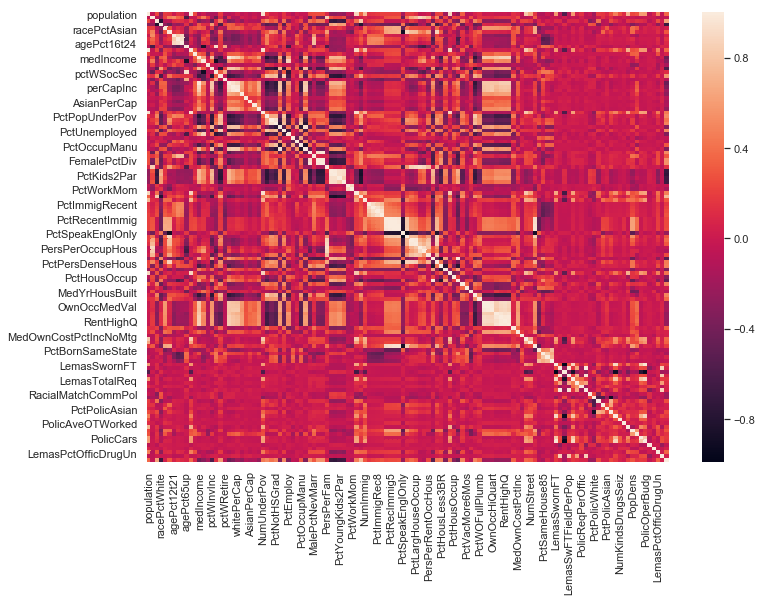

In [29]:
corr = data.corr()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(corr)


##### (d) Calculate Coefficient of Variation CV

In [3]:
CV = pd.DataFrame(index=data.columns)
CV['CV'] = [None]*data.shape[1]
for col in data.columns:
    CV.loc[col] = data[col].var() /data[col].mean()
CV.head()


,CV
population,0.279637
householdsize,0.0578408
racepctblack,0.357587
racePctWhite,0.0790155
racePctAsian,0.283898


##### (d) Select features with highest CV and generate scatter and box plots

Number of features: 11.0
                           CV
LemasPctOfficDrugUn  0.614103
NumStreet            0.442534
racePctHisp          0.375306
NumInShelters        0.357634
racepctblack         0.357587
NumIlleg             0.325382
PctUsePubTrans       0.324496
PctNotSpeakEnglWell   0.32058
PctRecImmig5         0.306673
PctRecentImmig       0.306553
PctRecImmig8         0.303318


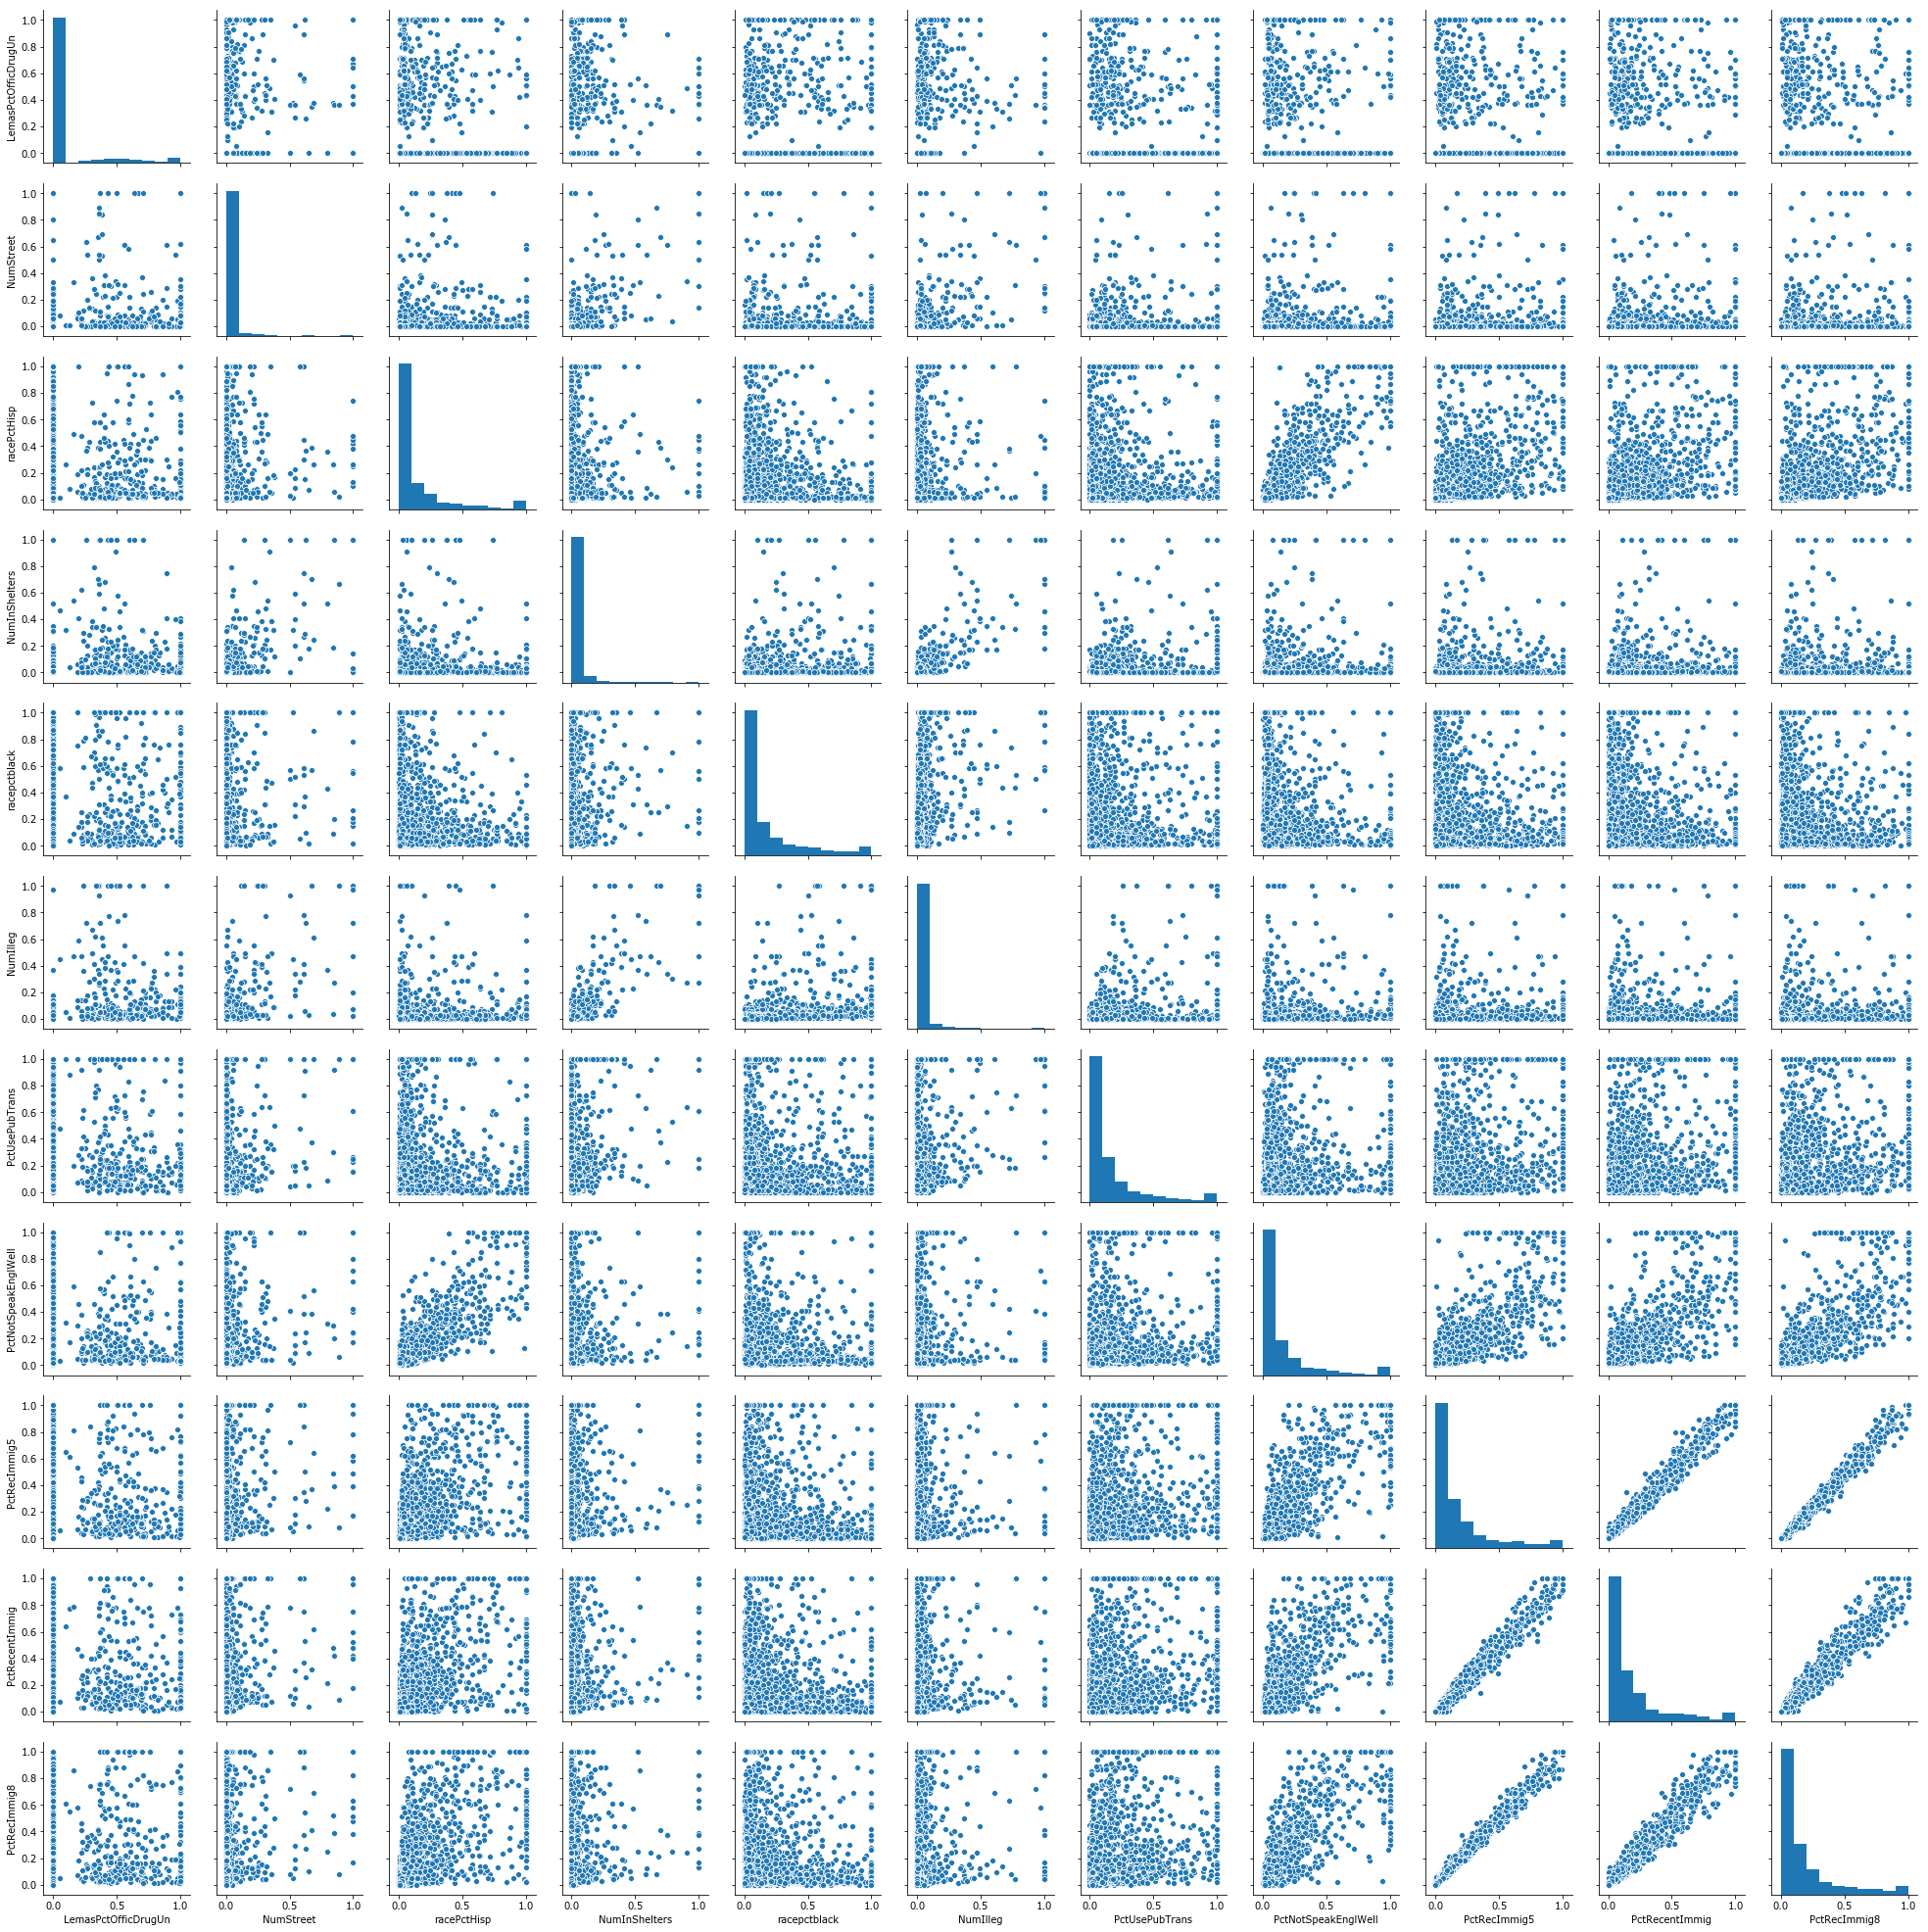

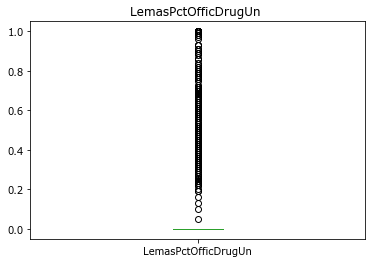

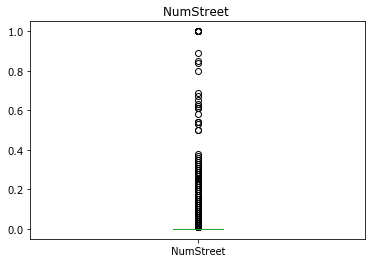

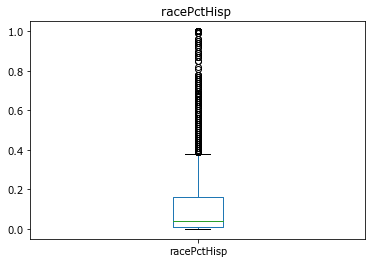

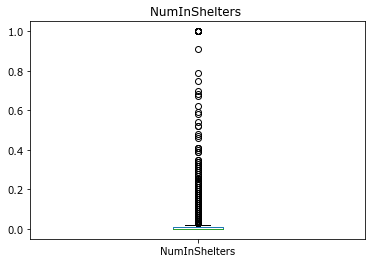

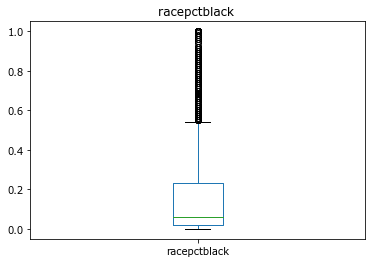

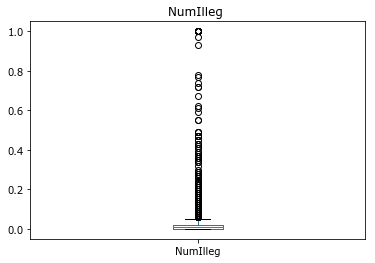

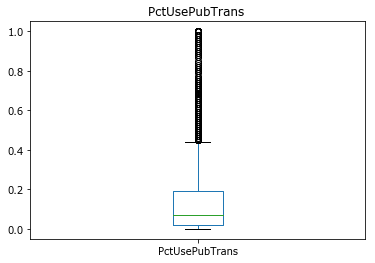

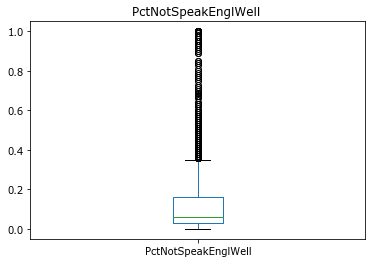

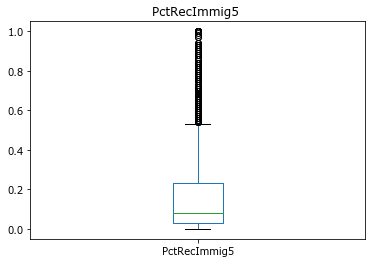

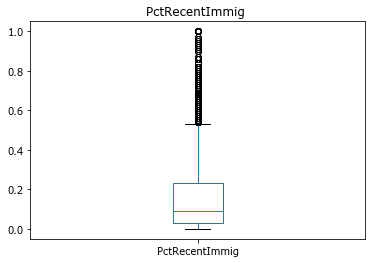

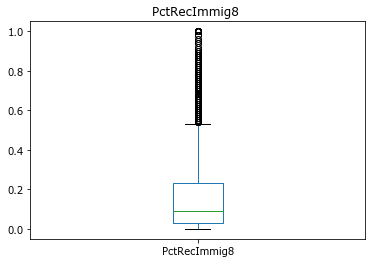

In [5]:
n_features = np.floor(np.sqrt(128))
print('Number of features:', n_features)
best = CV.sort_values(by='CV',ascending=False)[0:int(n_features)]
print(best)
sns.pairplot(data.loc[:,best.index])
for i in best.index:
    plt.figure()
    bp = data.loc[:,i]
    #bp = pd.DataFrame(StandardScaler().fit_transform(bp.values),columns=bp.columns)
    bp.plot.box()
    plt.title('{} '.format(i))

The features selected have no correlation except for 3. This is ideal for implementing regression.

Based off the box plots, the features have a high variance as the IQR is kept at a low minimum.

##### Set up training and test data

In [6]:
Xtrain = data.loc[0:1494,data.columns!='ViolentCrimesPerPop']
Ytrain = np.ravel(data.loc[0:1494,data.columns=='ViolentCrimesPerPop'])

Xtest = data.loc[1495:,data.columns!='ViolentCrimesPerPop']
Ytest = np.ravel(data.loc[1495:,data.columns=='ViolentCrimesPerPop'])


##### (f)Fit a linear model using LS

In [7]:
model = OLS(Ytrain,Xtrain).fit()

Ytrain_pred = model.predict(Xtrain)
mse_tr = sum(Ytrain - np.array(Ytrain_pred))/Xtrain.shape[0]
print('Train MSE: \t\t\t',mse_tr)


Ytest_pred = model.predict(Xtest)
mse_test = sum(Ytest - np.array(Ytest_pred))/Xtest.shape[0]
print('Test MSE: \t\t\t',mse_test)

Train MSE: 			 7.0064762979970845e-06
Test MSE: 			 0.030867721535478485


##### (g) Fit a Ridge Regression 

In [41]:
kfold = KFold(5)
ridge = RidgeCV(cv = kfold).fit(Xtrain,Ytrain)
Ytest_error = ridge.score(Xtest,Ytest)
print('Test Error for Ridge Regression:\t\t', 1 - Ytest_error)


Test Error for Ridge Regression:		 0.37297800429306305


##### (h) Fit a Lasso regression

In [42]:
lasso = LassoCV(cv = kfold,max_iter = 1e5).fit(Xtrain,Ytrain)
Ytest_error = lasso.score(Xtest,Ytest)
print('Test Error for Lasso Model:\t\t',1 - Ytest_error)

# Fit lasso on standardized features
Xtrain_std = StandardScaler().fit_transform(Xtrain)
Xtest_std = StandardScaler().fit_transform(Xtest)

lasso = LassoCV(cv = kfold,max_iter = 1e5).fit(Xtrain_std,Ytrain)
Ytest_error = lasso.score(Xtest_std,Ytest)
print('Test Error for Lasso Model (Standardized Features):\n', 
              1 - Ytest_error)

Test Error for Lasso Model:		 0.37352954982498143
Test Error for Lasso Model (Standardized Features):
 0.3784734482381651


##### (i) PCR

In [10]:
df_i = pd.DataFrame()
df_i['M'] = range(1,123)
df_i.set_index('M',inplace=True)
r = 1
for i in range(1,123):
    pca = PCA(n_components = i).fit(Xtrain)
    X_reduced = pd.DataFrame(pca.fit_transform(Xtrain))
    
    kfold = KFold(5).split(X_reduced)    
    cv = 0
    for tr,val in kfold:
        model = LinearRegression().fit(X_reduced.loc[tr],Ytrain[tr])
        cv = cv + model.score(X_reduced.loc[val],Ytrain[val])
    df_i.loc[r,'M'] = cv/5
    r = r + 1
    
# Find number the best number of components to use, M
Mind = np.argmax(df_i.values)
M = df_i.index[Mind]

pca = PCA(n_components = M).fit(Xtrain)
X_reduced = pd.DataFrame(pca.fit_transform(Xtrain))
model = LinearRegression().fit(X_reduced, Ytrain)

X_test_reduced = pd.DataFrame(pca.fit_transform(Xtest))
m_testerr = 1 - model.score(X_test_reduced,Ytest)
print('Test Error for PCR Model with M = ', M, ':\n', 1 - m_testerr)

Test Error for PCR Model with M =  96 :
 0.3903286637497143


##### (j) Boosting Tree

In [12]:
dtrain = xgb.DMatrix(Xtrain,label=Ytrain)
dtest = xgb.DMatrix(Xtest,label = Ytest)

df_j = pd.DataFrame()
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]
#alpha = np.arange(0,1,1)
alpha[-1] = 1
df_j['alpha'] = alpha
df_j['CV Error'] = [None] * df_j['alpha'].shape[0]


num_round = 50
r = 0
for alpha in df_j['alpha'].values:    
    kfold = KFold(5).split(Xtrain)
    cv = 0
    for tr, val in kfold:
        bst = xgb.XGBRegressor(objective = 'reg:linear',max_depth=1,reg_alpha=alpha,nthread = 4,
                               reg_lambda=0).fit(Xtrain.loc[tr],Ytrain[tr])
        cv = cv + bst.score(Xtrain.loc[val],Ytrain[val])
    df_j.loc[r,'CV Error'] = 1 - cv / 5
    print('alpha: ', alpha, '\t CV Error', 1 - cv/5)
    r = r + 1

print('Optimal alpha: \n', 1e-06)

alpha:  1e-06 	 CV Error 0.3494159807678059
alpha:  1e-05 	 CV Error 0.3494159771366778
alpha:  0.0001 	 CV Error 0.349416078176372
alpha:  0.001 	 CV Error 0.34942596218682165
alpha:  0.01 	 CV Error 0.34875130193811466
alpha:  0.1 	 CV Error 0.34859441176963113
alpha:  1.0 	 CV Error 0.3501462588813882
Optimal alpha: 
 1e-06


 Optimal alpha: 1e-06

#  2. Tree-Based Models

##### (a) Load Data

In [2]:
train = pd.read_csv('aps_failure_training_set.csv',skiprows=range(0,20))
test = pd.read_csv('aps_failure_test_set.csv',skiprows=range(0,20))
data = pd.concat([test,train])
data.reset_index(drop = True,inplace=True)
Y = data.loc[:,'class']

##### (b) i Fill in missing values 


###### Method used: Mean 

In [3]:
data.replace(to_replace= 'na', value= np.nan, inplace=True)
data= data.loc[:,data.columns!='class'].astype('float')
nans = data.loc[:,data.isna().any()].columns
# Relpace missing values with means of associated predictor
means = data.mean()
for col in nans:
    if sum(np.isnan(data[col].values)) > 0:
        new = []
        for elem in data[col].values:
            if np.isnan(elem) == True:
                new.append(means[col])
            else:
                new.append(elem)
        data[col] = new 
data['class'] = Y

##### (b) ii Calucate Coefficient of Variation

In [13]:
CV = pd.DataFrame(index=data.columns)
CV.drop('class',axis = 0,inplace=True)
CV['CV'] = [None]*(data.shape[1] -1)
for col in CV.index:
    CV.loc[col] = data[col].var() / data[col].mean()
CV.head()

,CV
aa_000,1.14594e+06
ab_000,3.44269
ac_000,1.67481e+09
ad_000,6.43699e+09
ae_000,3348.32


##### (b) iii Correlation Matrix

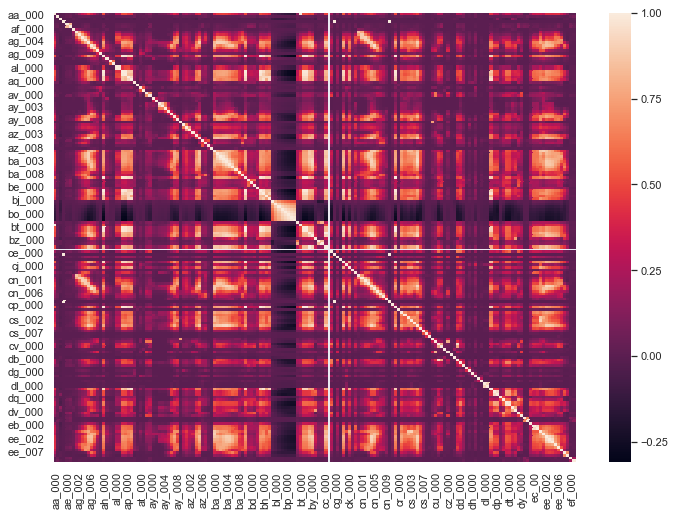

In [35]:
corr = data.iloc[:,0:170].corr()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(corr)

Many of the features appear to be highly uncorrelateled. 

##### (b) iv Select Features and generate scatter and box plots 

Number of features: 13.0
                 CV
cf_000  6.45408e+09
co_000   6.4418e+09
ad_000  6.43699e+09
dq_000  1.95461e+09
ac_000  1.67481e+09
eb_000  2.04757e+08
df_000  8.68183e+07
dh_000  5.46052e+07
dl_000  4.05075e+07
cs_009  3.79868e+07
du_000  3.22196e+07
ay_001  2.74909e+07
bb_000  2.66275e+07


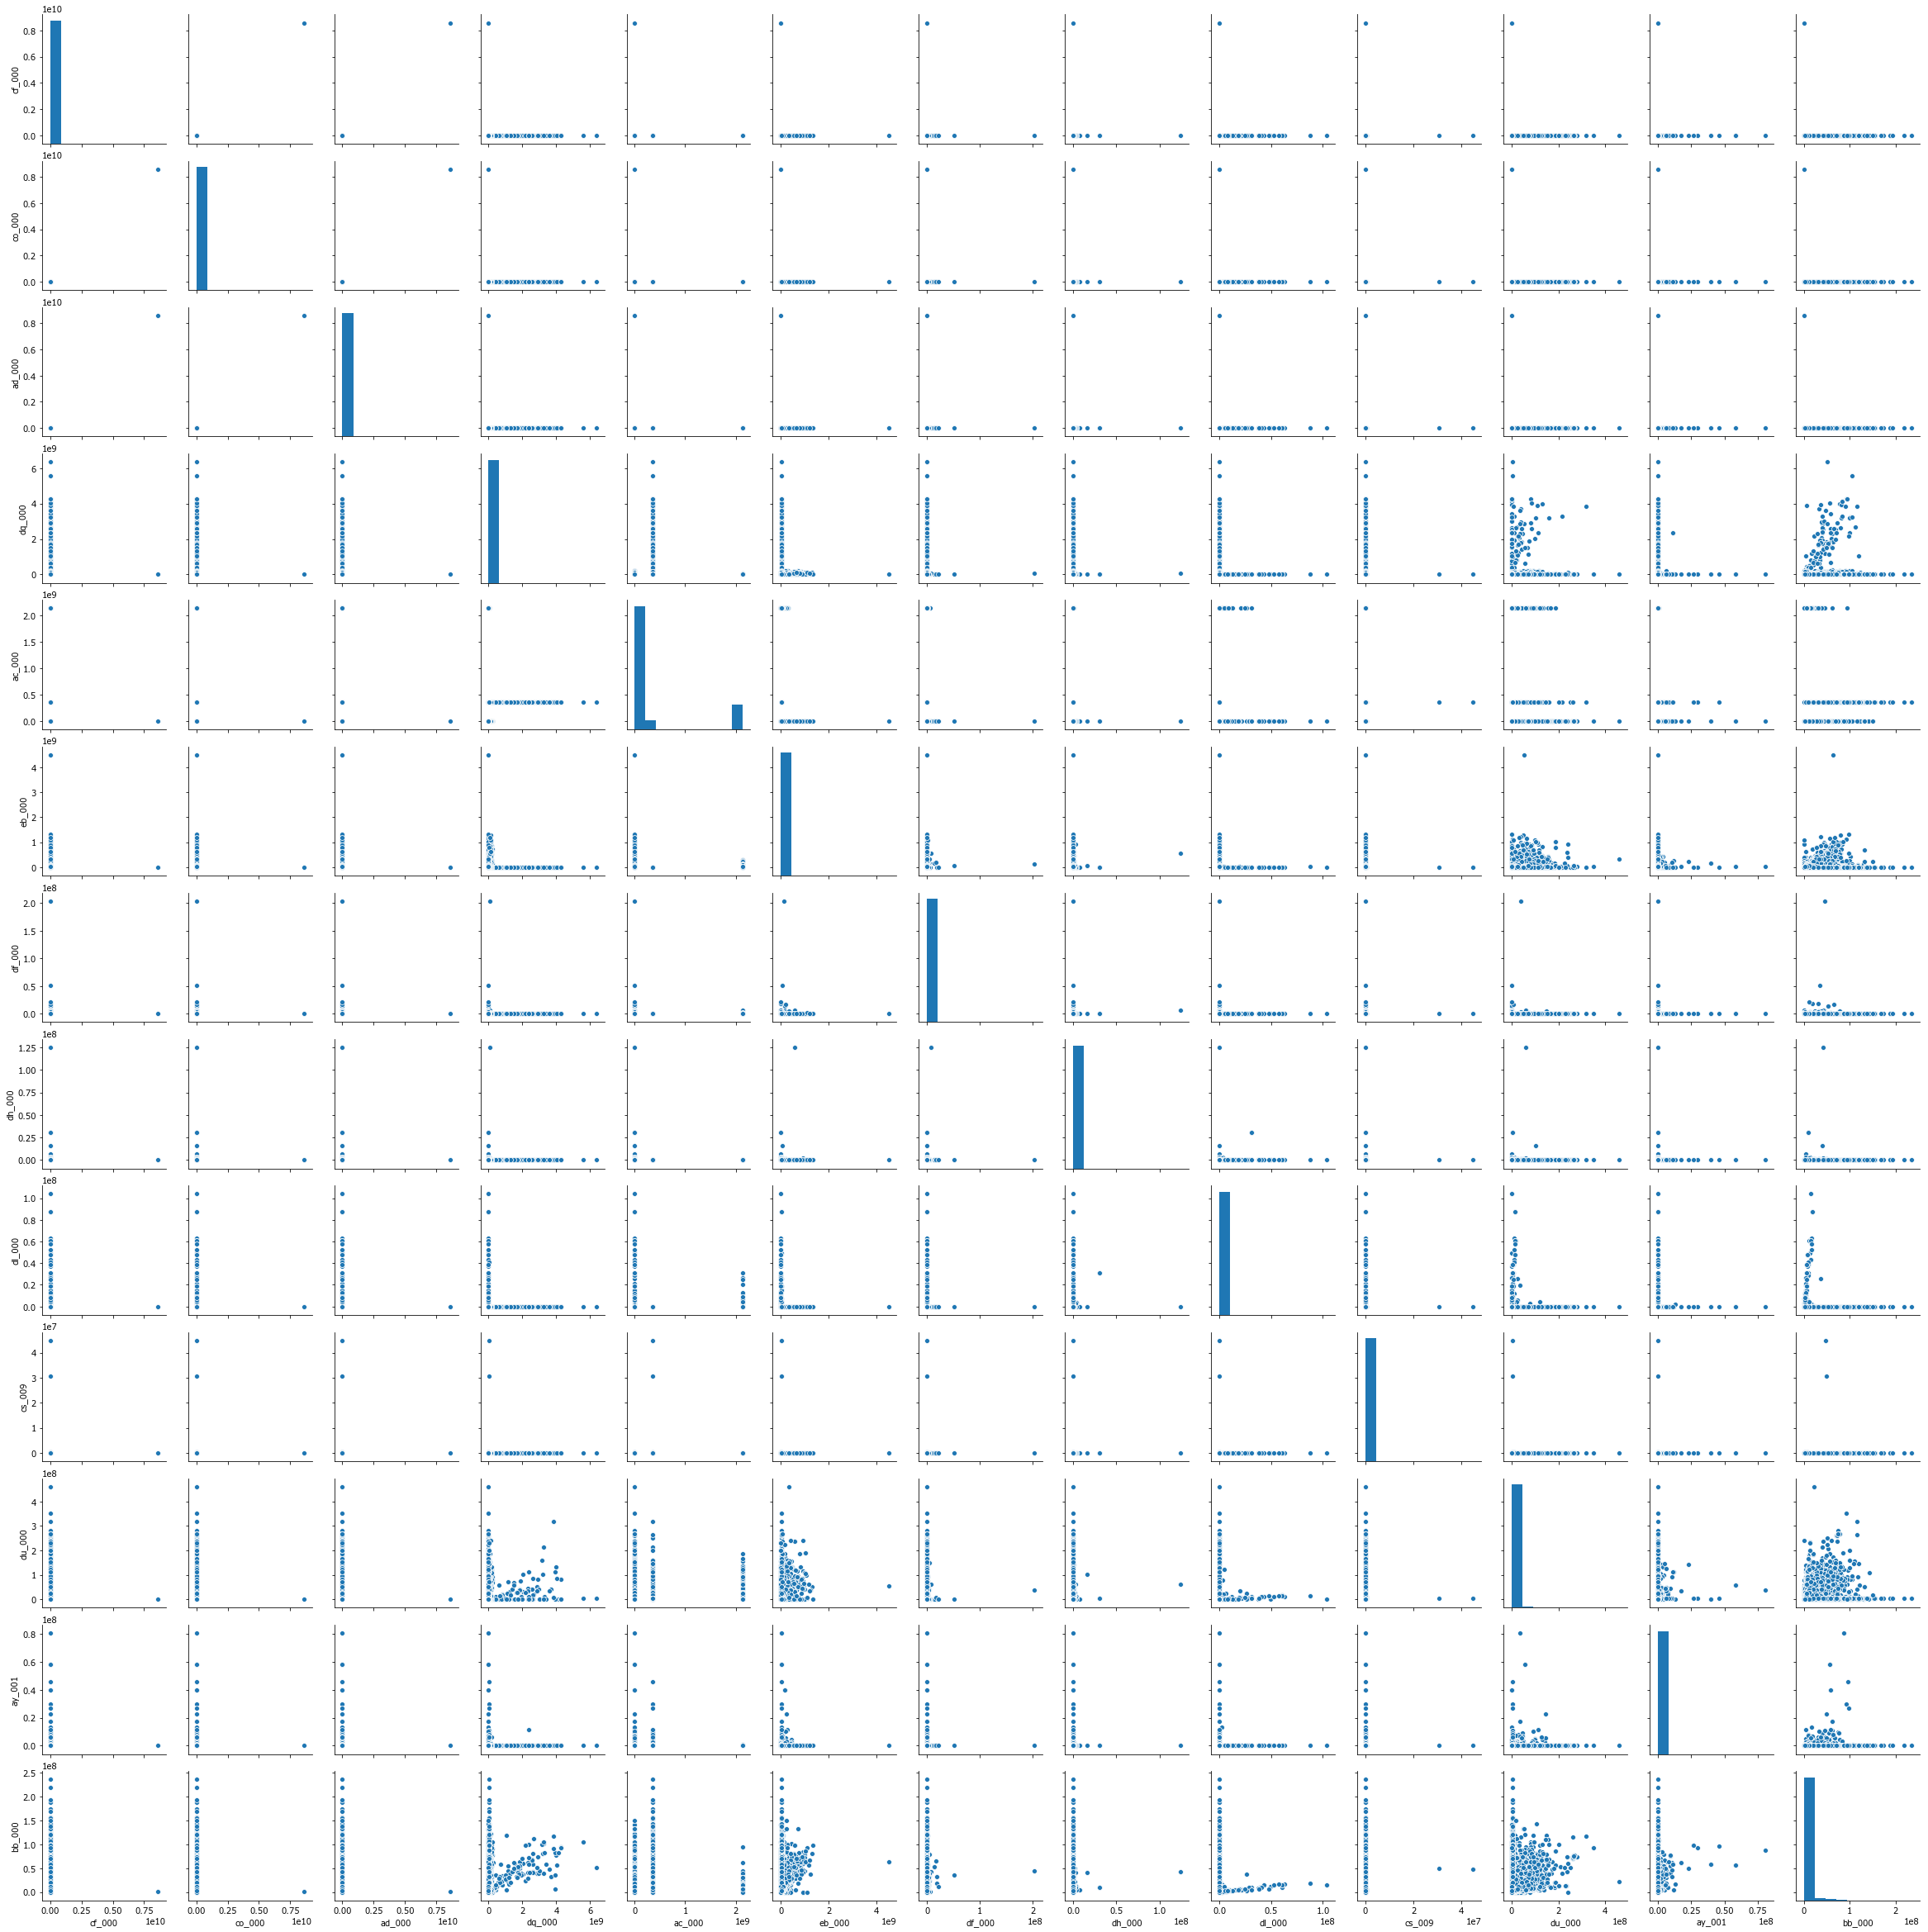

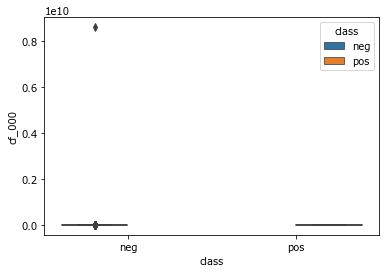

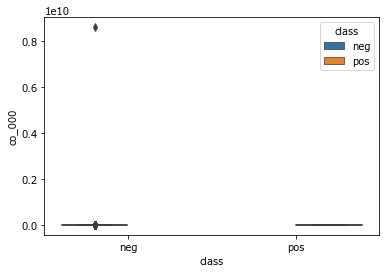

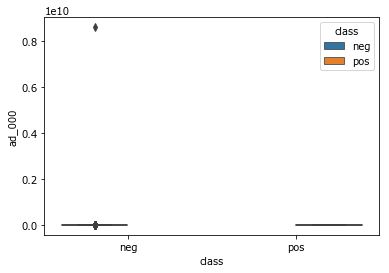

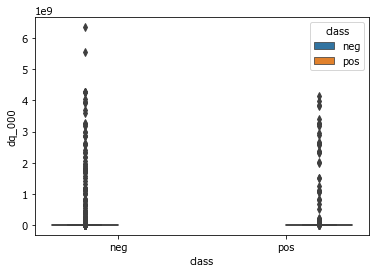

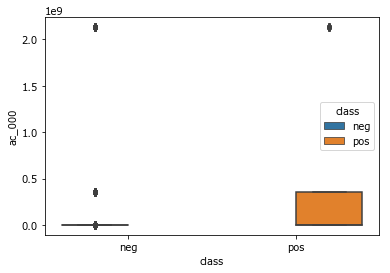

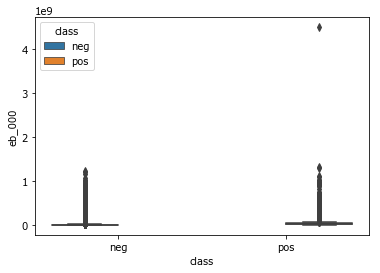

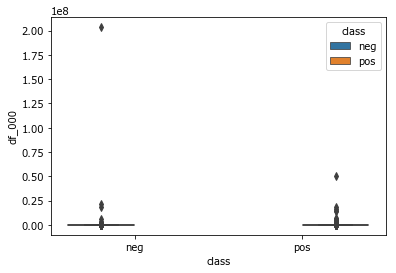

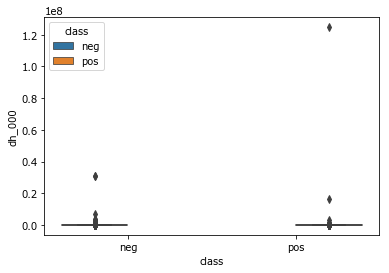

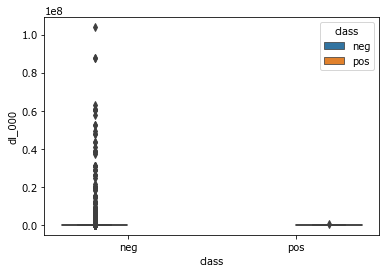

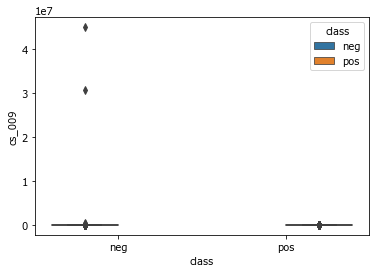

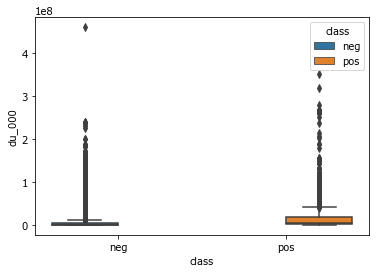

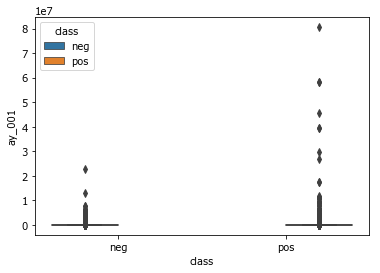

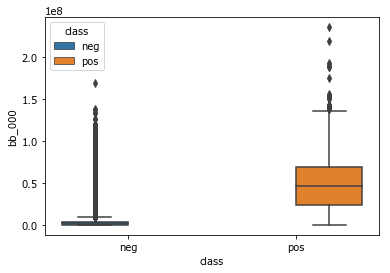

In [14]:
n_features = np.floor(np.sqrt(170))
print('Number of features:', n_features)
best = CV.sort_values(by='CV',ascending=False)[0:int(n_features)]
print(best)
sns.pairplot(data.loc[:,best.index])
for i in best.index:
    plt.figure()
    bp = data.loc[:,['class',i]]
    sns.boxplot(x='class', y=i, hue='class', data = bp)
    

Based of the scatter plots the selected features are uncorrelated. 

Box Plots:
cf_00: small spread of values for both classes with a few outliers for negative class

oo_000: small spread of values for both classes with a few outliers for negative class

ad_000: small spread of values for both classes with a few outliers for negative class

dq_000: small spread of values and lots of outliers for both classes

ac_000: small spread of values with several outliers for negative class
        larger spread than negative with few a few outliers for positive class
        
eb_000: small spread of values and lots of outliers for both classes

df_000: small spread of values and few outliers for both classes

dh_000: small spread of values and few outliers for both classes

dl_000: small spread of values and lots of outliers for negative class
        small spread of values and few outliers for postive class
        
cs_009: small spread of values and few outliers for negative class
        small spread of values and no outliers for postive class
       
du_000: larger spread than previous mentioned features with  lots of outliers negative class
        larger spread than negative class with lots of outliers for postive class
        
ay_001: small spread of values and lots of outliers for both classes

bb_000: larger spread than previous mentioned features with lots of outliers negative class
         much larger spread than negative class with fewer outliers than negative class  for postive class


##### (b)iv Class Sizes

In [62]:
pos_mask = data.loc[:,'class'] == 'pos'
pos = sum(pos_mask)
print('Number of Postive labels: \t\t', pos)
neg = sum(~pos_mask == 1)
print('Number of Negative labels: \t\t', neg)

Number of Postive labels: 		 1375
Number of Negative labels: 		 74625


This dataset is imbalanced.

2% - target class
98% - negative class

##### Set up training and test DF

In [4]:
Xtrain = data.loc[0:59999,data.columns!='class']
Ytrain = np.ravel(data.loc[0:59999,data.columns=='class'])
print(train.shape)
Xtest = data.loc[60000:,data.columns!='class']
Ytest = np.ravel(data.loc[60000:,data.columns=='class'])
print(test.shape)

(60000, 171)
(16000, 171)


##### (c) Train a Random Forest

Confusion matrix for training set: 
 [[58867     0]
 [    0  1133]]
Misclassification Rate: 
 0.0
Confusion matrix for test set: 
 [[15735    23]
 [   67   175]]
Misclassification Rate: 
 0.005624999999999991
OOB Error:
 0.006650000000000045


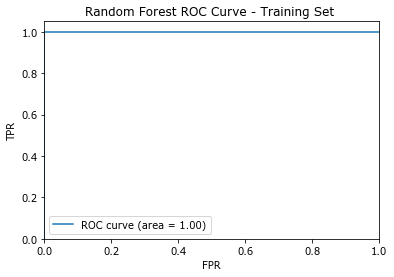

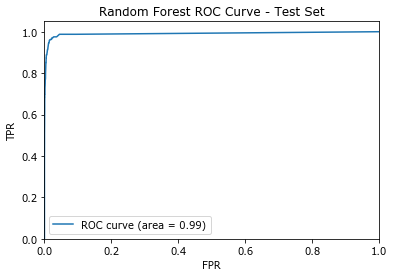

In [50]:
rf = RandomForestClassifier(n_estimators = 100,oob_score=True,random_state = 20).fit(Xtrain,Ytrain)
# Training results
Ypred = rf.predict(Xtrain)
confusion = confusion_matrix(Ytrain,Ypred)
print('Confusion matrix for training set: \n', confusion)
train_score = accuracy_score(Ytrain,Ypred,normalize=True)
print('Misclassification Rate: \n',(1-train_score))
      
train_pred = rf.predict_proba(Xtrain)
fpr, tpr ,_  = roc_curve(Ytrain, train_pred[:,1],pos_label='pos')
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr,tpr, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Random Forest ROC Curve - Training Set ')
plt.legend()

# Testing results
Ypred = rf.predict(Xtest)
confusion = confusion_matrix(Ytest,Ypred)
print('Confusion matrix for test set: \n', confusion)
test_score = accuracy_score(Ytest,Ypred,normalize=True)
print('Misclassification Rate: \n',(1-test_score))
print('OOB Error:\n', 1 - rf.oob_score_)

train_pred = rf.predict_proba(Xtest)
fpr, tpr ,_  = roc_curve(Ytest, train_pred[:,1],pos_label='pos')
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr,tpr, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Random Forest ROC Curve - Test Set')
plt.legend()



Training Set:
>-  No misclassification error rate - hence AUC = 1.

Testing Set:
>-  Misclassification error rate < OOB Score for training set

            0.0056 < 0.0066
>-  False Positive Rate: 0.0013
>-  True Positive Rate: 0.707
>-  False Negative Rate: 0.293
>-  True Negatve Rate: 0.999


The Random forest does not have any issues predicting the negative class as expected since the dataset is imbalanced.  

##### (d) Train a random forest taking the class imbalance into account

Confusion matrix for training set: 
 [[58867     0]
 [    0  1133]]
Misclassification Rate: 
 0.0
Confusion matrix for test set: 
 [[15725    33]
 [   76   166]]
Misclassification Rate: 
 0.006812499999999999
OOB Error:
 0.0010532216691864216


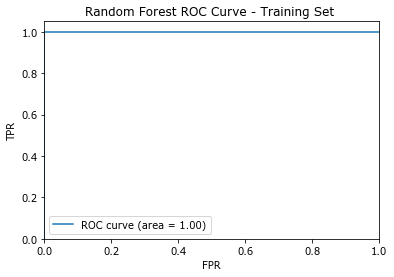

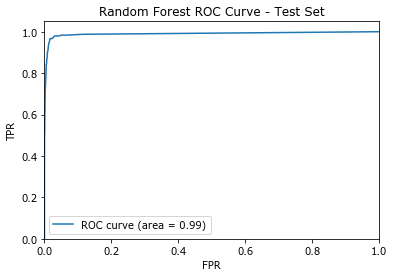

In [9]:

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

X_resampled, y_resampled = ros.fit_resample(Xtrain, Ytrain
                                           )
rf = RandomForestClassifier(n_estimators = 100,oob_score=True,random_state = 20
                            ).fit(X_resampled,y_resampled)
# Training results
Ypred = rf.predict(Xtrain)
confusion = confusion_matrix(Ytrain,Ypred)
print('Confusion matrix for training set: \n', confusion)
train_score = accuracy_score(Ytrain,Ypred,normalize=True)
print('Misclassification Rate: \n',(1-train_score))
      
train_pred = rf.predict_proba(Xtrain)
fpr, tpr ,_  = roc_curve(Ytrain, train_pred[:,1],pos_label='pos')
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr,tpr, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Random Forest ROC Curve - Training Set ')
plt.legend()

# Testing results
Ypred = rf.predict(Xtest)
confusion = confusion_matrix(Ytest,Ypred)
print('Confusion matrix for test set: \n', confusion)
test_score = accuracy_score(Ytest,Ypred,normalize=True)
print('Misclassification Rate: \n',(1-test_score))
print('OOB Error:\n', 1 - rf.oob_score_)

train_pred = rf.predict_proba(Xtest)
fpr, tpr ,_  = roc_curve(Ytest, train_pred[:,1],pos_label='pos')
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr,tpr, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Random Forest ROC Curve - Test Set')
plt.legend()

Training Set:
>-  No misclassification error rate - hence AUC = 1.

Testing Set:
>-  Misclassification error rate > OOB Score for training set

            0.0068 > 0.0010
>-  False Positive Rate: 0.002
>-  True Positive Rate: 0.68
>-  False Negative Rate: 0.32
>-  True Negatve Rate: 0.999
>> The Random forest does not have any issues predicting the negative class as expected since the dataset is imbalanced.  




Accounting for the class imbalance did not improve the model as anticpated. 
The method used was oversampling the minority class training data. 


##### (e) Model Trees -- univariate tree

In [5]:
import os
import traceback
import weka.core.jvm as jvm

from weka.core.converters import Loader
from weka.classifiers import Classifier, FilteredClassifier
    #PredictionOutput, Kernel, KernelClassifier
from weka.classifiers import Evaluation,PredictionOutput
from weka.filters import Filter
from weka.core.classes import Random, from_commandline
import weka.plot.classifiers as plot_cls
import weka.plot.graph as plot_graph

from weka.core.classes import Random
from weka.core.converters import Loader
from weka.core.dataset import Instances

jvm.start(packages=True)



DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/javabridge/jars/rhino-1.7R4.jar', '/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/javabridge/jars/runnablequeue.jar', '/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/javabridge/jars/cpython.jar', '/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support enabled


In [30]:
jvm.stop()

In [6]:
loader = Loader("weka.core.converters.CSVLoader")
train = loader.load_file('hw3_train.csv')
train.class_index = 170
test = loader.load_file('hw3_test.csv')
test.class_index = 170

Evaluation done
CV Done
CV Error Rate: 0.008583333333333333
Train
Eval summary:
 
Correctly Classified Instances       59621               99.3683 %
Incorrectly Classified Instances       379                0.6317 %
Kappa statistic                          0.8129
Mean absolute error                      0.0105
Root mean squared error                  0.0714
Relative absolute error                 28.3086 %
Root relative squared error             52.4872 %
Total Number of Instances            60000     

areaUnderROC/1: 0.9852704597110326
confusionMatrix: 
[[58780.    87.]
 [  292.   841.]]
correct: 59621.0
incorrect: 379.0
Building classifier done
Test:
[0. 0. 0. ... 0. 0. 0.]
Eval summary:
 
Correctly Classified Instances       15867               99.1688 %
Incorrectly Classified Instances       133                0.8313 %
Kappa statistic                          0.6956
Mean absolute error                      0.0117
Root mean squared error                  0.0814
Relative absolute er

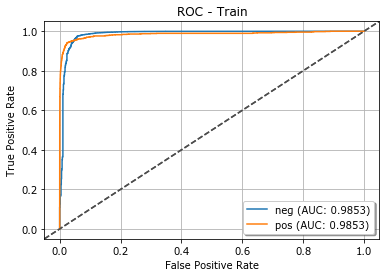

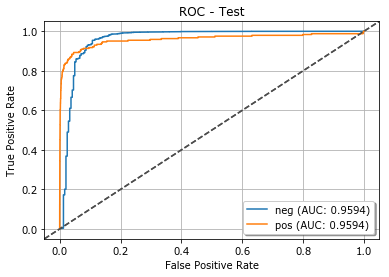

In [11]:
folds = 5
classifier = Classifier(classname="weka.classifiers.trees.LMT")

# Perform k-fold CV
evaluation = Evaluation(train)
print('Evaluation done')
evaluation.crossvalidate_model(classifier,train,folds,Random(42)) 
print('CV Done')
print('CV Error Rate:', evaluation.error_rate)

# build and evaluate classifier on test
# Results for LMT
evaluation = Evaluation(train)
cls = Classifier(classname="weka.classifiers.trees.LMT")
cls.build_classifier(train)
evl = evaluation.test_model(cls,train)

print('Train')
print('Eval summary:\n',evaluation.summary())
print("areaUnderROC/1: " + str(evaluation.area_under_roc(1)))
print("confusionMatrix: \n" + str(evaluation.confusion_matrix))
print("correct: " + str(evaluation.correct))
print("incorrect: " + str(evaluation.incorrect))

try:
    plot_cls.plot_roc(evaluation, title="ROC - Train",class_index=[0,1], wait=False)
except:
    print('No ROC')

print('Building classifier done')

evaluation = Evaluation(test)
evl = evaluation.test_model(cls, test)

print('Test:')
print(evl)
print('Eval summary:\n',evaluation.summary())
print("areaUnderROC/1: " + str(evaluation.area_under_roc(1)))
print("confusionMatrix: \n" + str(evaluation.confusion_matrix))
print("correct: " + str(evaluation.correct))
print("incorrect: " + str(evaluation.incorrect))
try:
    plot_cls.plot_roc(evaluation, title="ROC - Test",class_index=[0,1], wait=False)
except:
    print('No ROC')

CV Error Rate: 

     0.00858


*Training Data*

Train MSE: 0.005


Confusion Matrix:

        [[58780.    87.]
         [  292.   841.]]
AUC: 

    0.9853
    
*Testing Data*

CV : 0.00858 

Testing MSE: 0.0066

    The CV Error rate is a good estimate for the test set MSE.
    
Confusion Matrix:

       [[15712.    46.]
        [   87.   155.]]
AUC: 

    0.9594

##### (f) apply SMOTE to LMT

In [4]:
import weka.core.packages as packages
#packages.install_package("SMOTE")

CV Error Rate: 0.00935
train
Eval summary:
 
Correctly Classified Instances       59896               99.8267 %
Incorrectly Classified Instances       104                0.1733 %
Kappa statistic                          0.9527
Mean absolute error                      0.0045
Root mean squared error                  0.0399
Relative absolute error                 12.0649 %
Root relative squared error             29.2955 %
Total Number of Instances            60000     

areaUnderROC/1: 0.9959921471518867
confusionMatrix: 
[[5.8828e+04 3.9000e+01]
 [6.5000e+01 1.0680e+03]]
correct: 59896.0
incorrect: 104.0
test
Eval summary:
 
Correctly Classified Instances       15851               99.0687 %
Incorrectly Classified Instances       149                0.9313 %
Kappa statistic                          0.7147
Mean absolute error                      0.0113
Root mean squared error                  0.0892
Relative absolute error                 37.7442 %
Root relative squared error             7

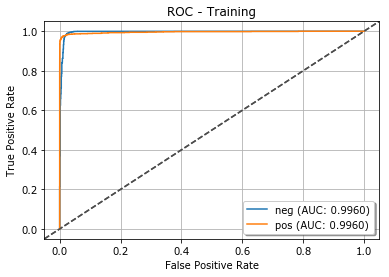

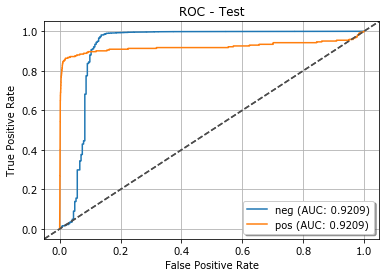

In [12]:
classifier = Classifier(classname="weka.classifiers.trees.LMT")
smote = Filter(classname="weka.filters.supervised.instance.SMOTE", options=["-C", "0", "-K", "5", "-P", "200.0", "-S", "1"])

fc = FilteredClassifier()
fc.filter = smote
fc.classifier = classifier

evaluation = Evaluation(train)
evaluation.crossvalidate_model(fc,train, 5,Random(42))

print('CV Error Rate:', evaluation.error_rate)
    
    
cls = Classifier.make_copy(classifier)
fc = FilteredClassifier()
fc.filter = smote
fc.classifier = cls

evaluation = Evaluation(train)
fc.build_classifier(train)
evaluation.test_model(fc,train)

# Train
try:
    plot_cls.plot_roc(evaluation, title="ROC - Training",class_index=[0,1], wait=False)
except:
    print('no ROC')
    
print('train')
print('Eval summary:\n',evaluation.summary())
print("areaUnderROC/1: " + str(evaluation.area_under_roc(1)))
print("confusionMatrix: \n" + str(evaluation.confusion_matrix))
print("correct: " + str(evaluation.correct))
print("incorrect: " + str(evaluation.incorrect))


# Test
evaluation = Evaluation(test)
evl = evaluation.test_model(fc,test)
print('test')
print('Eval summary:\n',evaluation.summary())
print("areaUnderROC/1: " + str(evaluation.area_under_roc(1)))
print("confusionMatrix: \n" + str(evaluation.confusion_matrix))
print("correct: " + str(evaluation.correct))
print("incorrect: " + str(evaluation.incorrect))
try:
    plot_cls.plot_roc(evaluation, title="ROC - Test",class_index=[0,1], wait=False)
except:
    print('No ROC')

CV Error Rate: 

     0.00935


*Training Data*

Train MSE: 0.0016


Confusion Matrix:

        [[5.8828e+04 3.9000e+01]
         [6.5000e+01 1.0680e+03]]
AUC: 

    0.9960
    
*Testing Data*

CV : 0.00935 

Testing MSE: 0.0079

    The CV Error rate is a good estimate for the test set MSE. Better than the case for not accounting for the class imbalance.
    
Confusion Matrix:

       [[15712.    46.]
        [   87.   155.]]
AUC: 

    0.9209



###### Comparison with uncompensated SMOTE using test set:

Precision for LMT: 0.64

Recall for LMT: 0.77

CV for LMT: 0.00858

Precision for LMT - SMOTE: 0.64

Recall for LMT - Smote: 0.77

CV for LMT - SMOTE: 0.00935

Based off the CV score, the model that didn't apply SMOTE performs better. Comparing the precision and recall for the test set there is no advantage to using SMOTE. The training set's precision and recall had both increased however, this is because the model was trained with SMOTE applied to the trianing set so it is not surprising that the values increased.